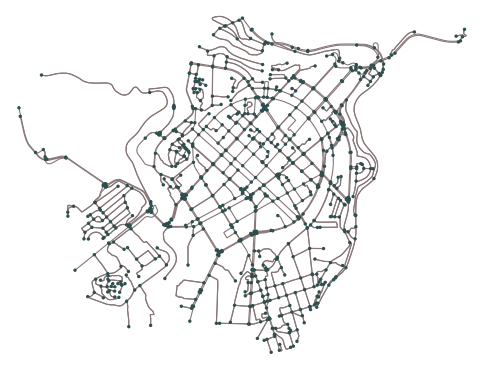

In [ ]:
import os
import osmnx as ox
import networkx as nx

# ---------- config: pick a tiny test area ----------
PLACE = "Kentron, Yerevan, Armenia"   # small; fast for smoke tests
NETWORK = "drive"


# ---------- download (simplify=True by default here) ----------
G = ox.graph.graph_from_place(PLACE, network_type=NETWORK, simplify=True)

# keep only the largest connected component (weak is fine for roads)
G = ox.truncate.largest_component(G, strongly=False)

keep_node = {"x", "y", "street_count"}
keep_edge = {"length", "highway", "name", "maxspeed"}

# for _, d in G.nodes(data=True):
#     for k in list(d.keys()):
#         if k not in keep_node:
#             d.pop(k, None)

# for u, v, k, d in G.edges(keys=True, data=True):
#     for kk in list(d.keys()):
#         if kk not in keep_edge:
#             d.pop(kk, None)
fig, ax = ox.plot.plot_graph(
    G,
    figsize=(6, 6),
    bgcolor="white",
    node_color="#1dd6d6",
    node_size=6,
    edge_color="#A47376",
    edge_linewidth=0.8,
    show=False,
    close=False,
)

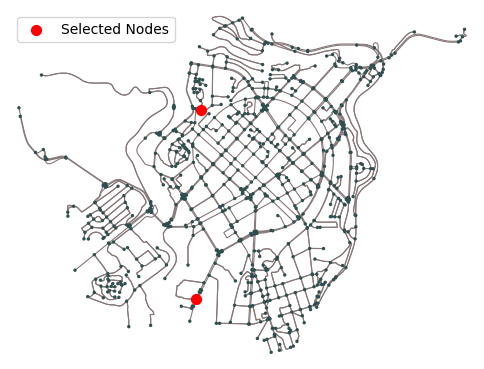

In [10]:
highlight_nodes = [256031437, 13237851232]  # replace with real node IDs

# get node coordinates
x_coords = [G.nodes[n]["x"] for n in highlight_nodes if n in G.nodes]
y_coords = [G.nodes[n]["y"] for n in highlight_nodes if n in G.nodes]

# replot with highlight
fig, ax = ox.plot.plot_graph(
    G,
    figsize=(6, 6),
    bgcolor="white",
    node_color="#2f4f4f",
    node_size=6,
    edge_color="#877778",
    edge_linewidth=0.8,
    show=False,
    close=False,
)

# plot the chosen nodes in red
ax.scatter(x_coords, y_coords, c="red", s=50, zorder=5, label="Selected Nodes")
ax.legend()

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/osmnx/_overpass.py:271: UserWarning: This area is 17 times your configured Overpass max query area size. It will automatically be divided up into multiple sub-queries accordingly. This may take a long time.
  multi_poly_proj = utils_geo._consolidate_subdivide_geometry(poly_proj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/osmnx/_overpass.py:271: UserWarning: This area is 16 times your configured Overpass max query area size. It will automatically be divided up into multiple sub-queries accordingly. This may take a long time.
  multi_poly_proj = utils_geo._consolidate_subdivide_geometry(poly_proj)


Syunik settlements: 50, links: 150


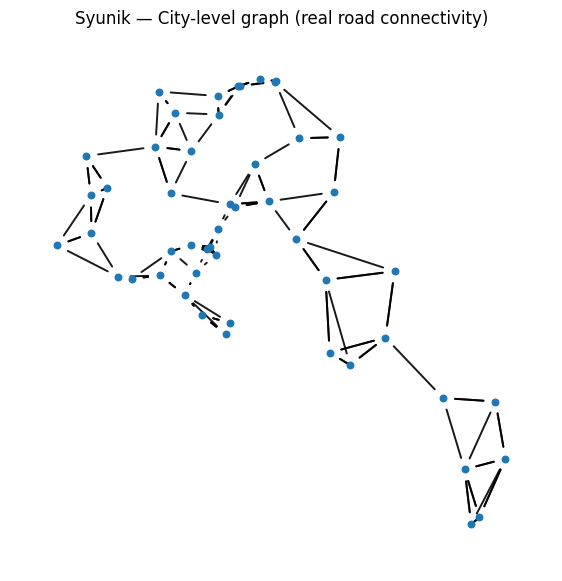

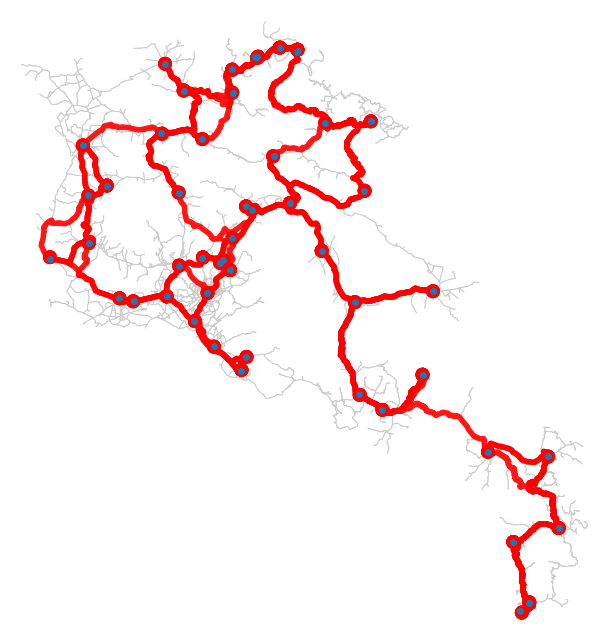

In [ ]:
# pip install osmnx networkx geopandas shapely folium
import osmnx as ox
import networkx as nx
import geopandas as gpd
import matplotlib.pyplot as plt
from shapely.geometry import Point

ox.settings.use_cache = True
ox.settings.log_console = False

PLACE = "Armenia"        # <- exact string you asked for
HIGHWAYS = "motorway|trunk|primary|secondary|tertiary"
CUSTOM_FILTER = f'["highway"~"{HIGHWAYS}"]'

# 0) Boundary polygon for Syunik
syunik = ox.geocode_to_gdf(PLACE).to_crs(4326)                           # geocoding/boundary
poly = syunik.geometry.iloc[0]

# 1) Intercity road network inside the province
G = ox.graph.graph_from_polygon(                                          # graph builder
    poly, network_type="drive", simplify=True, custom_filter=CUSTOM_FILTER
)
G = ox.truncate.largest_component(G, strongly=False)                      # keep main component

# 2) Settlements (cities + towns) inside the province
sett = ox.features.features_from_polygon(poly, tags={"place": ["city", "town"]})
sett = sett[~sett.geometry.is_empty].copy()

def to_point(geom):   # many are polygons; contract to a representative point
    return geom if geom.geom_type == "Point" else geom.centroid

sett["rep_point"] = sett.geometry.apply(to_point)
name_col = "name:en" if "name:en" in sett.columns else "name"
sett["label"] = sett[name_col].astype(str)

sett = sett.loc[:, ["label", "rep_point"]].drop_duplicates("label")
sett = gpd.GeoDataFrame(sett, geometry="rep_point", crs="EPSG:4326")

# 3) Map each settlement to nearest road-node in G
xs = sett["rep_point"].x.values
ys = sett["rep_point"].y.values
nearest_nodes = ox.distance.nearest_nodes(G, X=xs, Y=ys)                  # vectorized nearest
sett["graph_node"] = nearest_nodes

# 4) Build a city-level MultiGraph with real road connectivity only
def gc_km(a: Point, b: Point):
    # great-circle distance in km using OSMnx v2 distance API
    return ox.distance.great_circle(a.y, a.x, b.y, b.x) / 1000.0

coords = sett.set_index("label")["rep_point"].to_dict()
nodes  = sett.set_index("label")["graph_node"].to_dict()
labels = list(coords.keys())

k = 3           # connect to k geographically closest neighbors
radius_km = 90  # only if within this crow-flies radius

H = nx.MultiGraph()
for lbl in labels:
    H.add_node(lbl, x=coords[lbl].x, y=coords[lbl].y, graph_node=nodes[lbl])

for u in labels:
    # k-nearest by crow-flies
    neigh = sorted(
        ((v, gc_km(coords[u], coords[v])) for v in labels if v != u),
        key=lambda x: x[1]
    )[:k]

    for v, crow in neigh:
        if crow > radius_km:
            continue
        u_node, v_node = nodes[u], nodes[v]
        try:
            length_m = nx.shortest_path_length(G, u_node, v_node, weight="length")
            path = nx.shortest_path(G, u_node, v_node, weight="length")
        except nx.NetworkXNoPath:
            continue  # do not connect artificially
        H.add_edge(u, v,
                   length_m=length_m,
                   length_km=length_m/1000.0,
                   crow_km=crow,
                   road_path=path)

print(f"Syunik settlements: {H.number_of_nodes()}, links: {H.number_of_edges()}")

# ---- Visualization A: static city-level graph
pos = {n: (H.nodes[n]["x"], H.nodes[n]["y"]) for n in H.nodes}
plt.figure(figsize=(7,7))
nx.draw_networkx_nodes(H, pos, node_size=22)
nx.draw_networkx_edges(H, pos, width=1.4, alpha=0.9)
# nx.draw_networkx_labels(H, pos, font_size=7)  # uncomment to label
plt.title("Syunik — City-level graph (real road connectivity)")
plt.axis("off")
plt.show()

# ---- Visualization B: overlay each city-to-city *road path* on the OSM graph
edge_paths = [d["road_path"] for _, _, d in H.edges(data=True)]
fig, ax = ox.plot_graph_routes(
    G, edge_paths,
    route_linewidth=2.0, route_alpha=0.9,
    node_size=0, edge_color="#cccccc", edge_linewidth=0.6,
    bgcolor="white", show=False, close=False
)
ax.scatter([H.nodes[n]["x"] for n in H.nodes],
           [H.nodes[n]["y"] for n in H.nodes], s=16, zorder=5)
plt.show()


In [ ]:
# Saving
import pickle


with open("H_Armenia_drive.pkl", "wb") as f:
    pickle.dump(H, f, protocol=pickle.HIGHEST_PROTOCOL)

In [ ]:
# Loading
with open("H_Armenia_drive.pkl", "rb") as f:
    H2 = pickle.load(f)

In [ ]:
# loading
G2 = ox.io.load_graphml("/Users/armanmacbook/Documents/gitutyun_ev_krtutyun/courses/AI/project/src/G_graph_Armenia_drive.graphml") 

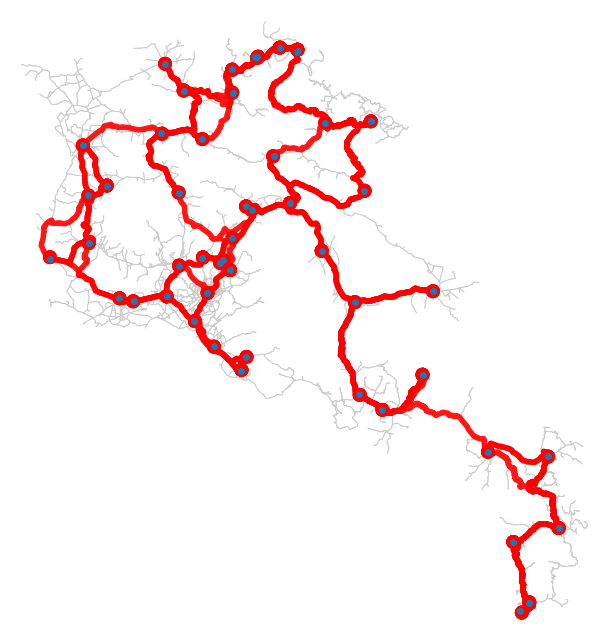

In [26]:
edge_paths = [d["road_path"] for _, _, d in H2.edges(data=True)]
fig, ax = ox.plot_graph_routes(
    G2, edge_paths,
    route_linewidth=2.0, route_alpha=0.9,
    node_size=0, edge_color="#cccccc", edge_linewidth=0.6,
    bgcolor="white", show=False, close=False
)
ax.scatter([H.nodes[n]["x"] for n in H.nodes],
           [H.nodes[n]["y"] for n in H.nodes], s=16, zorder=5)
plt.show()